In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split

from utils import *

### Test multiple classification methods with the original data

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Clearly feature engineering isn't really an option here since we are dealing with SVD modes.


| Columns       | Description |
|:------------- |:-------------|
| amount        | amount of transaction in cents|
| time          | time of transaction in seconds|
| class         | boolean fraudulent/legitimate-->1/0|
| V\*           | SVD features (US in svd USV')|

In [3]:
fradulent = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

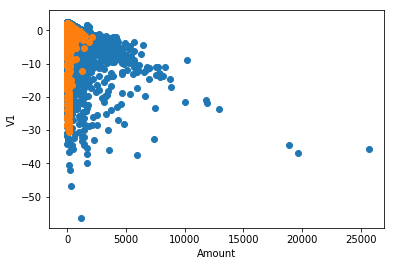

In [4]:
ax = plt_features('Amount','V1',data)
plt.show()

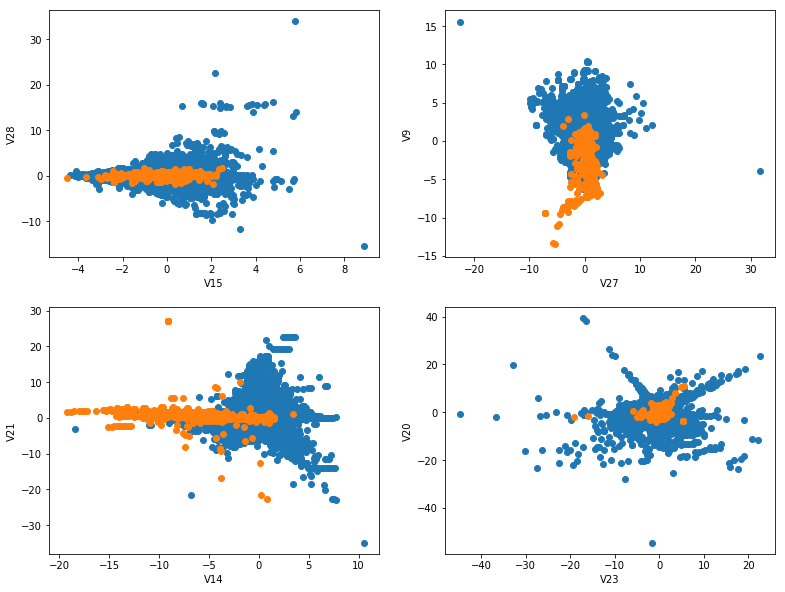

In [5]:
col_names = list(data.columns)[1:-1] ## TODO what is this?
tile_random_features(col_names, data)
# list(np.random.choice(col_names, 2, replace=False)) + ['squat']

Data often doesn't look very Gaussian does it... We would expect those appraoches to be bad. We could try to restrict outselves to set of features that do look roughly gaussian.. but since that's prolly hard it's prolly best to simply use it naively and accept that it won't work very well.

KNN looks like a much more promising approach, granted we alter the cost function to predict the minority class when there are verrry few within the nearest k (maybe 1..). This sounds like a recipe for overfitting however. Perhaps to match this with SMOTE would make for good results.

SVM, or really any linear classifier, looks like it would perform poorly.

#### Prep data

In [4]:
train, test = train_test_split(data, test_size=0.2)

print '% of fraud cases in original, train, and test sets:'
print len(fradulent)*1.0/len(data)
print len(train[train['Class']==1])*1.0/len(train)
print len(test[test['Class']==1])*1.0/len(test)

% of fraud cases in original, train, and test sets:
0.00172748563062
0.00172485681055
0.00173800077244


In [5]:
# Split into features / class labels
train_x, train_y = [df.as_matrix() for df in split_by_class(train)]
test_x, test_y = [df.as_matrix() for df in split_by_class(test)]

### Implement classification methods

#### Gaussian Methods

It seems pretty absurd to use LDA here given that each class cannot be assumed to have the same covariance bsed on above plots. Let's try quadratic discriminant analysis instead and/or Naive Bayes.

In both cases I don't expect good results, and no clear way to improve them until we implement over/under sampling or synethetic data methods. We could impact the results by changing the priors for each class, but don't have a legit justification for doing so.

Naive Bayes is like QDA with diagonal covariance matrices--meaning the classes do not share covariance matrices but they do ensure a spherical MVN distribution.


In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

print "QDA"
qda = QuadraticDiscriminantAnalysis().fit(train_x, train_y)
print_metrics(test_y, qda.predict(test_x))

print ''
print "Naive Bayes"
nb = GaussianNB().fit(train_x, train_y)
print_metrics(test_y, nb.predict(test_x))

QDA
Recall: 	0.848484848485
Precision:	0.0565656565657
F1 Score:	0.106060606061
Accuracy:	0.975141322285
Confusion mat: 
[[55462  1401]
 [   15    84]]

Naive Bayes
Recall: 	0.606060606061
Precision:	0.146341463415
F1 Score:	0.235756385069
Accuracy:	0.993170885854
Confusion mat: 
[[56513   350]
 [   39    60]]


Surprisingly QDA actually did pretty well.

#### Decision Tree

See paper for write up on these trees

Details: Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important, since a tree with few samples in high dimensional space is very likely to overfit.

In [49]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(train_x, train_y)
print_metrics(test_y, tree.predict(test_x))

Precision:	0.722772277228
Recall: 	0.829545454545
F1 Score:	0.772486772487
Accuracy:	0.999245110776
Confusion mat: 
[[56846    28]
 [   15    73]]


#### KNN

KNN classifier uses a polling of data points closest to a the test point to determine which class it is. In the binary case the test point usually gets labelled as whichever class has more representation in the N neighbiors (like someone to quickly bows to social pressure). However if easy to see why that would greatly bias towards the majority class. You could weight it by distance but given that the classes look to overlap heavily I decided to tune it a different way.

Scikit didn't allow me to tune the built in classifier in the way I wanted so here is my own, built in scikit's NearestNeighbors algorithms. Essentially instead of each neighbor getting a equal vote for which class the test point should be I wanted the minorty class (hard coded here as 1 for convenience) to have a more impactful vote (not exactly democratic). In the most extreme case this means that if _any_ of the neighbors are members of the minority class then we assign the minority class to the test point as well.

Note: KNN is known to not perform well on high dimensioal data

In [10]:
from WeightedKNN import WeightedKNN

N = 9

weight = 1 # weight 1 means majority vote
print "Boring majority vote condition"
wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
print_metrics(test_y, wknn.predict(test_x),'')

weight = N # for all weight values > (N+1)/2  you get the one vote counts case
print "Vigilant condition: is fraud if _any_ neightbors are"
wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
print_metrics(test_y, wknn.predict(test_x),'')

weight = 3
print "Unequal voting: class 1 gets {} votes".format(weight)
wknn = WeightedKNN(n_neighbors=N, weight=weight, minority_class=1).fit(train_x, train_y)
print_metrics(test_y, wknn.predict(test_x),'')

Boring majority vote condition
Precision:	1.0
Recall: 	0.0227272727273
F1 Score:	0.0444444444444
Accuracy:	0.998490221551
Confusion mat: 
[[56874     0]
 [   86     2]]

Vigilant condition: is fraud if _any_ neightbors are
Precision:	0.0579345088161
Recall: 	0.261363636364
F1 Score:	0.0948453608247
Accuracy:	0.992293107686
Confusion mat: 
[[56500   374]
 [   65    23]]

Unequal voting: class 1 gets 3 votes
Precision:	0.565217391304
Recall: 	0.147727272727
F1 Score:	0.234234234234
Accuracy:	0.998507777115
Confusion mat: 
[[56864    10]
 [   75    13]]



Conclusion: Even in the 'vigilant' case this method doesn't do a great job on recall.

#### Logistic Regression

Generates probabiltities that a test point is in each class using the logistic regression function. You can also add a L1 or L2 regularization term. We don't have any reason to think that promoting sparisity on the input would be helpful here  but we will test it anyway.

In [6]:
# Vanilla version
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(class_weight='balanced') # class_weight is very important
logit.fit(train_x, train_y)

pred = logit.predict(test_x)
print_metrics(test_y, pred)

Recall: 	0.858585858586
Precision:	0.0648360030511
F1 Score:	0.120567375887
Accuracy:	0.978231101436
Confusion mat: 
[[55637  1226]
 [   14    85]]


Hey, pretty damn good! But let's use GRidSearch to find the best combination of hyperparameters

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'penalty':['l1','l2'], 'C': [1.0/1000, 1.0/100, 1./10, 1, 10], 'class_weight': ['balanced']}
 ]
gs = GridSearchCV(LogisticRegression(), param_grid, scoring='recall')
gs.fit(train_x, train_y)

Best parameters
{'penalty': 'l2', 'C': 0.01, 'class_weight': 'balanced'}


In [47]:
print 'Recall Scores'
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
print ''

print "Best parameters"
print gs.best_params_
print ''

print_metrics(test_y, gs.predict(test_x))

Recall Scores
0.939 (+/-0.027) for {'penalty': 'l1', 'C': 0.001, 'class_weight': 'balanced'}
0.938 (+/-0.026) for {'penalty': 'l2', 'C': 0.001, 'class_weight': 'balanced'}
0.941 (+/-0.028) for {'penalty': 'l1', 'C': 0.01, 'class_weight': 'balanced'}
0.942 (+/-0.024) for {'penalty': 'l2', 'C': 0.01, 'class_weight': 'balanced'}
0.940 (+/-0.025) for {'penalty': 'l1', 'C': 0.1, 'class_weight': 'balanced'}
0.940 (+/-0.025) for {'penalty': 'l2', 'C': 0.1, 'class_weight': 'balanced'}
0.940 (+/-0.025) for {'penalty': 'l1', 'C': 1, 'class_weight': 'balanced'}
0.940 (+/-0.025) for {'penalty': 'l2', 'C': 1, 'class_weight': 'balanced'}
0.940 (+/-0.025) for {'penalty': 'l1', 'C': 10, 'class_weight': 'balanced'}
0.940 (+/-0.025) for {'penalty': 'l2', 'C': 10, 'class_weight': 'balanced'}

Best parameters
{'penalty': 'l2', 'C': 0.01, 'class_weight': 'balanced'}

Precision:	0.0589907604833
Recall: 	0.943181818182
F1 Score:	0.111036789298
Accuracy:	0.976668656297
Confusion mat: 
[[55550  1324]
 [    5  

Not much different than the non-regularized version... so still good

#### The best 3 methods appear to be Logistic Regression and QDA, with Decision Trees being a little behind. KNN was poor.

### Other metrics

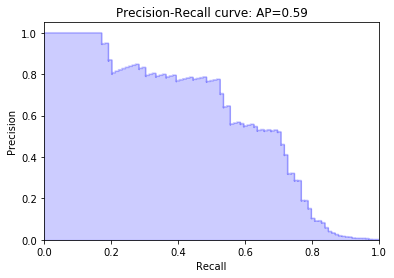

In [11]:
plot_pr(qda, test_x, test_y)

This isn't very useful because we don't really care much about the precision of class 1 classification. A low precision is acceptable. We really want our true negative rate (tn/fp+tn) or our accurancy (which is close to TN rate) to stay high. 

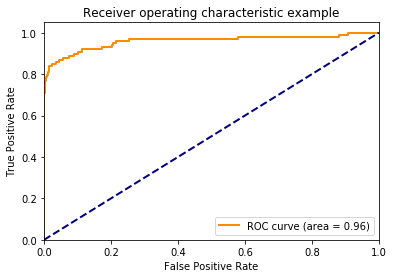

In [10]:
y_score = qda.decision_function(test_x)
plot_roc(test_y, y_score)

ROC/AUROC Are also not very helpful in this situation, since it tends to assume you want to reduce false classifications equally. Of course we still want to maximize the true positive rate (TPR) and minimize the false positive rate (FPR)